In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
num_replications = 50
np.random.seed(2)

In [3]:
## Historical data from 
# https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
Historical_results = pd.read_csv("data/results.csv")
Groups = pd.read_csv("data/World_Cup_Groups_temp.csv")

In [4]:
Historical_results["date"] = pd.to_datetime(Historical_results["date"],format = '%Y-%m-%d')
Modern_era = Historical_results[Historical_results["date"].dt.year>=1930].copy().reset_index()

We don't have a large historical pool of data if we analyze each team’s performance in world cup. Not all teams have several appearances in the world cup’s finals thus instead of calculating a team attack and defense score for the world cup, we’ll check if there's signigicant difference to calculate a world cup adjustment factor based in the average effect the event has in the team’s scoring metrics during the tournament.

### Initial comparisson between total matches and world cup matches.

We'll compare goals scored for home and away teams both in general and in world cup setting. 

In [5]:
print(Modern_era['home_score'].mean())
print(Modern_era['home_score'].std())
print(Modern_era['home_score'][Modern_era['tournament']=="FIFA World Cup"].mean())
print(Modern_era['home_score'][Modern_era['tournament']=="FIFA World Cup"].std())
print(" ")
print(Modern_era['away_score'].mean())
print(Modern_era['away_score'].std())
print(Modern_era['away_score'][Modern_era['tournament']=="FIFA World Cup"].mean())
print(Modern_era['away_score'][Modern_era['tournament']=="FIFA World Cup"].std())

1.7250369734268403
1.7410243515316546
1.568888888888889
1.4895740329550375
 
1.166118028720004
1.3838907469812465
1.2622222222222221
1.313960107088734


We don't need to calculate further. Given the standard deviations and means we can be sure that the difference will not be significant.

### Inspecting scores across time


In [6]:
Modern_era["year"]=Modern_era["date"].dt.year

Avg_goals = Modern_era.groupby("year").agg(home_score=("home_score", "sum"), away_score=("away_score", "sum"), home_team=("home_team", "count"), away_team=("away_team", "count"))
Avg_goals["Avg_goals_home"]=Avg_goals["home_score"]/Avg_goals["home_team"]
Avg_goals["Avg_goals_away"]=Avg_goals["away_score"]/Avg_goals["away_team"]

Avg_goals_FIFA = Modern_era[Modern_era['tournament']=="FIFA World Cup"].groupby("year").agg(home_score=("home_score", "sum"), away_score=("away_score", "sum"), home_team=("home_team", "count"), away_team=("away_team", "count"))
Avg_goals_FIFA["Avg_goals_home"]=Avg_goals_FIFA["home_score"]/Avg_goals_FIFA["home_team"]
Avg_goals_FIFA["Avg_goals_away"]=Avg_goals_FIFA["away_score"]/Avg_goals_FIFA["away_team"]

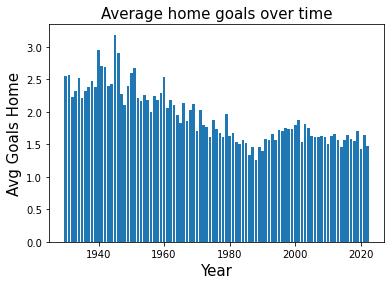

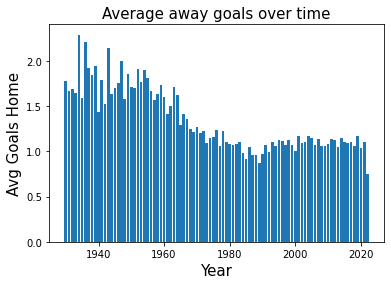

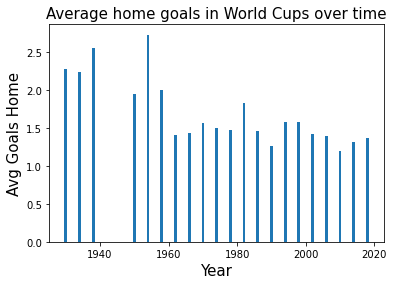

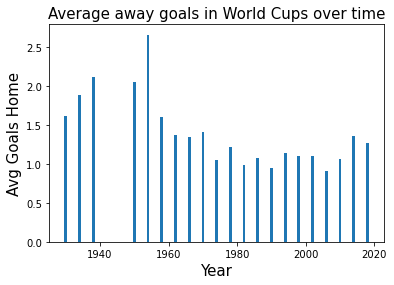

In [7]:
# Overall 
plt.bar(Avg_goals.index,Avg_goals["Avg_goals_home"])
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Avg Goals Home', fontsize = 15)
plt.title('Average home goals over time', fontsize = 15)
plt.show()

plt.bar(Avg_goals.index,Avg_goals["Avg_goals_away"])
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Avg Goals Home', fontsize = 15)
plt.title('Average away goals over time', fontsize = 15)
plt.show()

# World Cup
plt.bar(Avg_goals_FIFA.index,Avg_goals_FIFA["Avg_goals_home"])
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Avg Goals Home', fontsize = 15)
plt.title('Average home goals in World Cups over time', fontsize = 15)
plt.show()

plt.bar(Avg_goals_FIFA.index,Avg_goals_FIFA["Avg_goals_away"])
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Avg Goals Home', fontsize = 15)
plt.title('Average away goals in World Cups over time', fontsize = 15)
plt.show()


Since scores were higher in the first half of World Cup history, we can do an exponentially weighted average. This is to ensure scores are not too overinflated, our main concern should be on maintaining the differences between teams to reflect the teams attack and defense diferences to model how each match would have distinct distributions.

### Calculating exponentially weighted average

In [8]:
lst = [0]*len(Modern_era)
lst = pd.DataFrame(lst)
Modern_era["Weight"]=lst

In [9]:
lst2 = []
alpha = 0.2
for i in range(len(Avg_goals)):
    if i==0:
        lst2.append(alpha)
    else:
        lst2.append(alpha*(1-alpha)**i)


In [10]:
year = Avg_goals.index.tolist()
year.sort(reverse=True)
Weighted_alpha = pd.DataFrame(list(zip(year,lst2)), columns =["year","weight"])
Weighted_alpha

,year,weight
0,2022,2.000000e-01
1,2021,1.600000e-01
2,2020,1.280000e-01
3,2019,1.024000e-01
4,2018,8.192000e-02
...,...,...
88,1934,5.928555e-10
89,1933,4.742844e-10
90,1932,3.794275e-10
91,1931,3.035420e-10


In [11]:
for i in range(len(Weighted_alpha)):
    Modern_era["Weight"][Modern_era["year"]==Weighted_alpha["year"][i]] = Modern_era["Weight"][Modern_era["year"]==Weighted_alpha["year"][i]]+Weighted_alpha["weight"][i]

/var/folders/8m/32mdx6516gd3_96hfb027cd40000gn/T/ipykernel_99646/3569456374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Modern_era["Weight"][Modern_era["year"]==Weighted_alpha["year"][i]] = Modern_era["Weight"][Modern_era["year"]==Weighted_alpha["year"][i]]+Weighted_alpha["weight"][i]


In [12]:
Modern_era["weighted_home_score"]=Modern_era["home_score"]*Modern_era["Weight"]
Modern_era["weighted_away_score"]=Modern_era["away_score"]*Modern_era["Weight"]

In [13]:
print(Modern_era['weighted_home_score'].sum()/Modern_era['Weight'].sum())
print(Modern_era['weighted_away_score'].sum()/Modern_era['Weight'].sum())

1.6070117812269857
1.097330197174874


### Calculating the attack and defense strength score for each team

In [14]:
overal_scored_home = Modern_era['weighted_home_score'].sum()/Modern_era['Weight'].sum()
overal_scored_away = Modern_era['weighted_away_score'].sum()/Modern_era['Weight'].sum()
overal_conceded_home = overal_scored_away
overal_conceded_away = overal_scored_home

In [15]:

scored_home = []
scored_away = []
conceded_home = []
conceded_away = []

for i in range(len(Groups[["Squad"]])):
    scored_home.append(Modern_era[Modern_era['home_team']==Groups["Squad"][i]]['weighted_home_score'].sum()/Modern_era[Modern_era['home_team']==Groups["Squad"][i]]['Weight'].sum())
    scored_away.append(Modern_era[Modern_era['away_team']==Groups["Squad"][i]]['weighted_away_score'].sum()/Modern_era[Modern_era['away_team']==Groups["Squad"][i]]['Weight'].sum())
    conceded_home.append(Modern_era[Modern_era['home_team']==Groups["Squad"][i]]['weighted_away_score'].sum()/Modern_era[Modern_era['home_team']==Groups["Squad"][i]]['Weight'].sum())
    conceded_away.append(Modern_era[Modern_era['away_team']==Groups["Squad"][i]]['weighted_home_score'].sum()/Modern_era[Modern_era['away_team']==Groups["Squad"][i]]['Weight'].sum())

#World_Cup_Squads = Groups[["Squad"]].copy()    
Strength_score = pd.DataFrame(list(zip(scored_home,scored_away,conceded_home,conceded_away)), columns=["scored_home","scored_away","conceded_home","conceded_away"])
Strength_score["squad"] = Groups[["Squad"]].copy()
Strength_score["home_attack_strength"] = Strength_score["scored_home"]/overal_scored_home
Strength_score["away_attack_strength"] = Strength_score["scored_away"]/overal_scored_away
Strength_score["home_defense_strength"] = Strength_score["conceded_home"]/overal_conceded_home
Strength_score["away_defense_strength"] = Strength_score["conceded_away"]/overal_conceded_away
Strength_score = Strength_score[["squad","home_attack_strength","home_defense_strength","away_attack_strength","away_defense_strength","scored_home","scored_away","conceded_home","conceded_away"]]

In [16]:
Strength_score

,squad,home_attack_strength,home_defense_strength,away_attack_strength,away_defense_strength,scored_home,scored_away,conceded_home,conceded_away
0,Qatar,1.146089,0.849940,1.184321,0.906641,1.841779,1.299592,0.932665,1.456983
1,Ecuador,1.210902,0.960835,0.942464,0.902536,1.945934,1.034194,1.054353,1.450386
2,Senegal,1.018457,0.502884,1.242587,0.522253,1.636672,1.363528,0.551830,0.839267
3,Netherlands,1.506977,0.701496,1.716720,0.685350,2.421730,1.883808,0.769773,1.101366
4,England,1.364985,0.519800,2.099510,0.430821,2.193548,2.303856,0.570392,0.692334
5,Iran,1.451440,0.472137,1.718287,0.367076,2.332482,1.885528,0.518090,0.589895
6,United States,1.344365,0.659884,1.173872,0.775572,2.160410,1.288125,0.724110,1.246354
7,Argentina,1.123682,0.590684,1.567772,0.634296,1.805771,1.720364,0.648175,1.019322
8,Saudi Arabia,1.192148,0.776207,1.097469,0.737350,1.915796,1.204286,0.851756,1.184930
9,Mexico,1.132938,0.756782,1.357006,0.719940,1.820645,1.489084,0.830439,1.156951


### Simulating some matches to validate logic

I'm going to simulate one match with Qatar and another with other pair. 

I consider Qatar the only one with home advantange and so my initial idea is to use home strength only with Qatar and away for everyone else.

#### Qatar vs Ecuador

In [17]:
lambda_Qatar = Strength_score["home_attack_strength"][Strength_score["squad"]=="Qatar"][0]*Strength_score["away_defense_strength"][Strength_score["squad"]=="Ecuador"][1]*overal_scored_home
lambda_Ecuador = Strength_score["away_attack_strength"][Strength_score["squad"]=="Ecuador"][1]*Strength_score["home_defense_strength"][Strength_score["squad"]=="Qatar"][0]*overal_scored_away

In [18]:
for i in range(0,10):
    score_Qatar = round(np.random.poisson(lambda_Qatar))
    score_Ecuador = round(np.random.poisson(lambda_Ecuador))
    if score_Qatar>score_Ecuador:
        print("Qatar Wins! ", score_Qatar, " x ", score_Ecuador)
    elif score_Qatar==score_Ecuador:
        print("Draw! ", score_Qatar, " x ", score_Ecuador)
    else:
        print("Ecuador Wins! ", score_Ecuador, " x ", score_Qatar)

Draw!  1  x  1
Qatar Wins!  1  x  0
Qatar Wins!  1  x  0
Qatar Wins!  2  x  1
Qatar Wins!  4  x  1
Qatar Wins!  1  x  0
Qatar Wins!  1  x  0
Draw!  1  x  1
Qatar Wins!  2  x  0
Draw!  2  x  2


#### Portugal vs Uruguay

In [19]:
lambda_Portugal = Strength_score["away_attack_strength"][Strength_score["squad"]=="Portugal"][25]*Strength_score["away_defense_strength"][Strength_score["squad"]=="Uruguay"][27]*overal_scored_away
lambda_Uruguay = Strength_score["away_attack_strength"][Strength_score["squad"]=="Uruguay"][27]*Strength_score["away_defense_strength"][Strength_score["squad"]=="Portugal"][25]*overal_scored_away

In [20]:
for i in range(0,10):
    score_Portugal = round(np.random.poisson(lambda_Portugal))
    score_Uruguay = round(np.random.poisson(lambda_Uruguay))
    if score_Portugal>score_Uruguay:
        print("Portugal Wins! ", score_Portugal, " x ", score_Uruguay)
    elif score_Portugal==score_Uruguay:
        print("Draw! ", score_Portugal, " x ", score_Uruguay)
    else:
        print("Uruguay Wins! ", score_Uruguay, " x ", score_Portugal)

Portugal Wins!  2  x  0
Draw!  2  x  2
Portugal Wins!  2  x  0
Ecuador Wins!  3  x  1
Portugal Wins!  1  x  0
Portugal Wins!  1  x  0
Portugal Wins!  3  x  0
Portugal Wins!  3  x  0
Portugal Wins!  2  x  0
Portugal Wins!  2  x  0


In [22]:
lambda_Netherlands = Strength_score["home_attack_strength"][Strength_score["squad"]=="Netherlands"][3]*Strength_score["away_defense_strength"][Strength_score["squad"]=="Senegal"][2]*overal_scored_home
lambda_Senegal = Strength_score["away_attack_strength"][Strength_score["squad"]=="Senegal"][2]*Strength_score["home_defense_strength"][Strength_score["squad"]=="Netherlands"][3]*overal_scored_away

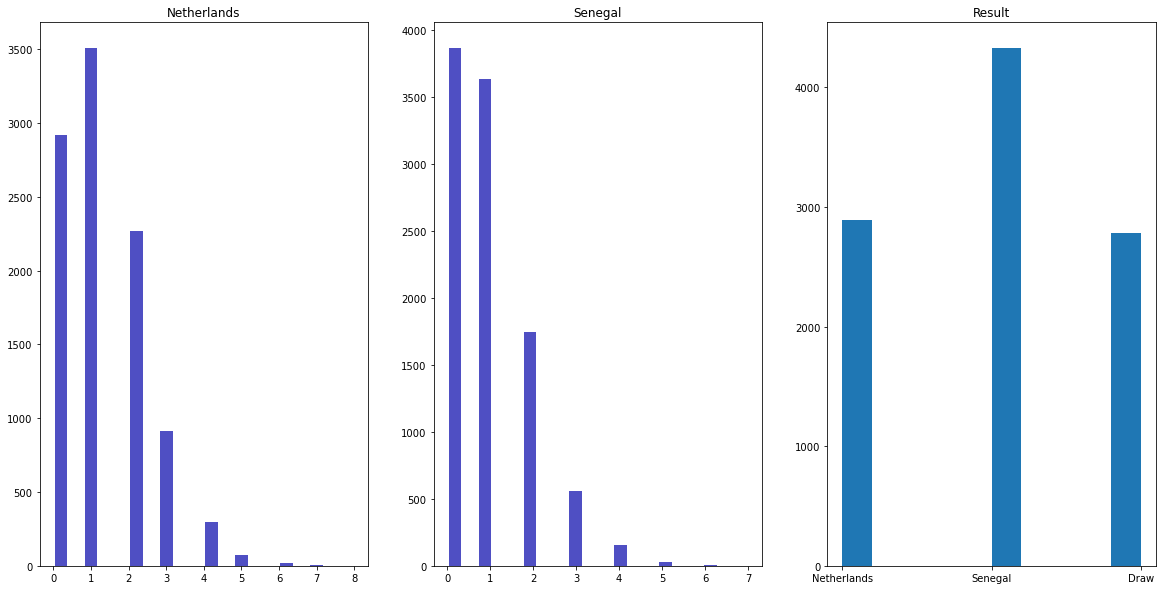

/opt/homebrew/Caskroom/miniconda/base/envs/bams503/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


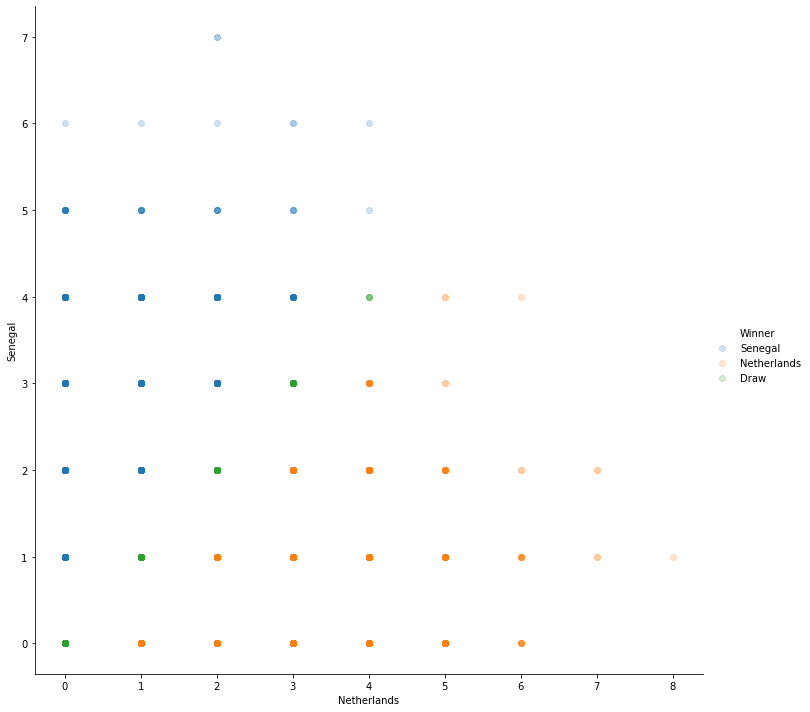

In [55]:
lst_winner = []
nscore = []
sscore = []
for i in range(0,10000):
    score_Netherlands = round(np.random.poisson(lambda_Netherlands))
    nscore.append(score_Netherlands)
    score_Senegal = round(np.random.poisson(lambda_Senegal))
    sscore.append(score_Senegal)
    if score_Netherlands>score_Senegal:
        #print("Netherlands Wins! ", score_Netherlands, " x ", score_Senegal)
        lst_winner.append("Netherlands")
    elif score_Netherlands==score_Senegal:
        #print("Draw! ", score_Netherlands, " x ", score_Senegal)
        lst_winner.append("Draw")
    else:
        #print("Senegal Wins! ", score_Senegal, " x ", score_Netherlands)
        lst_winner.append("Senegal")

df = pd.DataFrame(list(zip(nscore,sscore,lst_winner)), columns=["Netherlands","Senegal","Winner"])
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].hist(nscore, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
axs[0].set_title('Netherlands')
axs[1].hist(sscore, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
axs[1].set_title('Senegal')
axs[2].hist(lst_winner)
axs[2].set_title('Result')
axs[2].set_xticks(np.arange(0, 3, 1))
axs[2].set_xticklabels(['Netherlands', 'Senegal', 'Draw'])
_ = plt.show()

fg = sns.FacetGrid(data=df, hue='Winner', size=10)
fg.map(plt.scatter, 'Netherlands', 'Senegal',alpha=0.2).add_legend()

